# Visualize Birth Death Rates For a Given Folder
Tim Tyree<br>
8.12.2020

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt

#automate the boring stuff
# from IPython import utils
import time, os, sys, re
beep = lambda x: os.system("echo -n '\\a';sleep 0.2;" * x)
if not 'nb_dir' in globals():
    nb_dir = os.getcwd()
    
#load the libraries
from lib import *

%autocall 1
%load_ext autoreload
%autoreload 2
# awareness&chill

100000
Automatic calling is: Smart


# combine all of the relevant bdrates files within a given folder into one .csv

In [2]:
#find file interactively
print("please select a file from within the desired folder.")
file = search_for_file()

please select a file from within the desired folder.
File: /home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-2/ds_5_param_set_8_laurener_archive/archive-laurener/termination_times_ic_001-019.csv


In [16]:
#9 samples LT = 0
# file =  '/Users/timothytyree/Documents/GitHub/care/notebooks/Data/ds_5_param_set_8/birth-death-rates/33_ds_5_sigma_1.5_threshold_0.6__traj_sr_40_mem_2_bdrates.csv'

#>60 samples LT = 2
# file = '/Users/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-1/ds_5_param_set_8/birth-death-rates/ic_200x200.117.21_ds_5_sigma_1.5_threshold_0.6_sr_50_mem_2_tmin_100_LT_2_bdrates.csv'
#change to the directory containing file
folder_name = os.path.dirname(file)


#find folder interactively. Crashes jupyter's root kernel :(
# from tkinter import Tk
# from tkinter.filedialog import askdirectory
# path = askdirectory(title='Select Folder') # shows dialog box and return the path
# print(path) 

In [17]:
# get all .csv files in the current working directory
os.chdir(folder_name)
retval = !ls
file_name_list = list(retval)
# check each file if it ends in .csv before merging it
def is_csv(file_name):
    return file_name[-4:]=='.csv'
file_name_list = [f for f in file_name_list if is_csv(f)]
# remove all files with 'threshold'
# file_name_list = [f for f in file_name_list if f.find('threshold')==-1]

In [18]:
print(len(file_name_list))

110


In [19]:
def produce_one_csv(list_of_files, file_out):
   # Consolidate all csv files into one object
   result_obj = pd.concat([pd.read_csv(file) for file in list_of_files])
   # Convert the above object into a csv file and export
   result_obj.to_csv(file_out, index=False, encoding="utf-8")

In [20]:
# file_out = "../consolidated_rates.csv"
file_out = "../consolidated_rates-from-log-set-.csv"
produce_one_csv(list_of_files=file_name_list, file_out=file_out)

# visualize the consolidated_rates.csv

## visualize termination times

In [ ]:
searc

In [21]:
#sort a df into the rows with termination times and everything else
os.chdir(folder_name)
print(file_out)
df = pd.read_csv(file_out)
# np.nan values mark termination times/the final datum for a trial.
na_loc = df.isna().T.any()
df_term = df[na_loc].copy()
termination_times = df_term['t'].values  #lookup the time value for each such datum
# df_bd = df[~na_loc].copy() 

../consolidated_rates-from-log-set-A.csv


In [22]:
# #add zeros for the trials that terminated faster than 100ms
# total_num_trials = 19*9

# l = list(termination_times)
# while len(l)<total_num_trials:
#     l.append(0.)
# termination_times = np.array(l)

In [23]:
# awareness&chill
df.head()

,Unnamed: 0,t,n,dn,rates
0,0,0.025,24,-6.0,0.200000
1,2,5.025,18,-2.0,0.080000
2,7,17.525,16,2.0,0.200000
3,9,22.525,18,2.0,0.400000
4,10,25.025,20,-2.0,0.133333


In [24]:
print(f"""the mean termination time is 
                {10**-3*np.mean(termination_times):.1f} ± {10**-3*np.std(termination_times):.1f} s
                """)
print(f"""the median termination time is 
                {10**-3*np.median(termination_times):.1f} s (IQR:  {10**-3*np.quantile(termination_times, 0.25):.1f} s - {10**-3*np.quantile(termination_times, 0.75):.1f} s)
                """)
print(f"""the max termination time is {10**-3*np.max(termination_times):.0f} s""")
print(f'no. trials considered = {len(file_name_list)}.')

the mean termination time is 
                28.8 ± 32.9 s
                
the median termination time is 
                19.8 s (IQR:  7.9 s - 40.0 s)
                
the max termination time is 246 s
no. trials considered = 110.


In [13]:
3683**2

13564489

In [14]:
np.sum(termination_times)/(19*9)

11694.853801169591

In [117]:
r = 10**3/np.mean(termination_times)
def P(k,t):
    '''the probability that k events occur in time t'''
    return (r*t)**k*np.exp(-r*t)/np.math.factorial(k)

saved figure in 
	histogram_termination_times_suite-2.png.


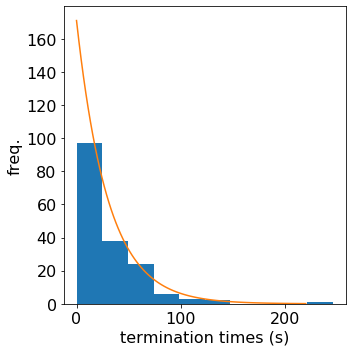

In [118]:
#plot the histogram of termination times
saving = True
fontsize=16

savefig_dir = f'{nb_dir}/Figures/birth_death_analysis'
savefig_fn = 'histogram_termination_times_suite-2.png'

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(np.array(termination_times)/10**3, bins = 10)

#overlay a poisson distribution
N = len(termination_times)
x_values = np.linspace(1,220000,100)/10**3
y_values = N*P(0,x_values)
ax.plot(x_values,y_values)

#format plot
# plt.title(f'''termination times for 9 200x200 patches''', fontsize=fontsize)
ax.set_ylabel('freq.', fontsize=fontsize)
ax.set_xlabel('termination times (s)', fontsize=fontsize)
ax.tick_params(axis='both', which='both', labelsize=fontsize)
# ax.set_ylim((0,80))
ax.set_yscale('log')
if not saving: 
    plt.show() 
else:
    plt.tight_layout()
    os.chdir(savefig_dir)
    plt.savefig(savefig_fn, dpi=300)
    print(f"saved figure in \n\t{savefig_fn}.")

In [82]:
# termination_times[termination_times>=10000]
print(r)

0.03306839777483597


In [45]:
# from scipy.stats import poisson

In [ ]:
ax.set_yscale('log')

In [109]:
# dist.pmf(5)
file_out

'../consolidated_rates-from-log.csv'

## visualize birth death rates

In [119]:
#import data
os.chdir(folder_name)
df = pd.read_csv(file_out)

#drop termination times
df.dropna(inplace=True)

#drop rows with rates over 100/ms
df = df.loc[df.rates<=9].copy()

# df = df.loc[df.rates<=0.02].copy()
df = df.loc[df.rates<=0.1].copy()

dn_list = sorted(set(df.dn.values))
dn_list = [-2,2]

In [106]:
np.mean(df.n.values)

9.058946975703027

In [120]:
#compute median rates and IQR for the error bars corresponding to each category in dn_list
errorbar_data_list = []
for dn in dn_list:  
    #iterate over n for each dn
    df2 = df.loc[df.dn==dn].copy()
    n_list = sorted(set(df2.n.values))
    y_val_list = []
    y_err_1_list = []
    y_err_2_list = []
    for n in n_list:
        df3 = df2.loc[df2.n == n].copy()
        y_val, y_err_1, y_err_2 = df3.describe().T[['50%', '25%', '75%']].loc['rates'].values
        y_err_2 = float(y_err_2 - y_val)
        y_err_1 = float(y_val - y_err_1)
        y_val = float(y_val)
        y_val_list.append(y_val)
        y_err_1_list.append(y_err_1)
        y_err_2_list.append(y_err_2)
    # errorbar_data = (dn, n_list, y_val_list, y_err_1_list, y_err_2_list)
    errorbar_data = {'dn':dn, 
                     'n_list':n_list, 
                     'y_val_list':y_val_list, 
                     'y_err_1_list':y_err_1_list, 
                     'y_err_2_list':y_err_2_list
                    }
    errorbar_data_list.append(errorbar_data)    

In [121]:
#retrieve scatter plot data points for each category in dn_list
scatter_data_list = []
for dn in dn_list:  
    df2 = df.loc[df.dn==dn].copy()
    x_values = df2.n.values
    y_values = df2.rates.values
    scatter_data = {'dn':dn, 
                     'x_values':x_values, 
                     'y_values':y_values, 
                    }
    scatter_data_list.append(scatter_data)

In [122]:
#assign a color/label/other formatting to each category in dn_list
color_list_raw = ['red', 'blue', 'green', 'orange', 'brown', 'purple']
formatting_data_list = []
for i, dn in enumerate(dn_list):
    formatting_data = {
        'dn': dn,
        'color': color_list_raw[i],
        'label':f'$W_{{{int(dn):+d}}}$'
    }
    formatting_data_list.append(formatting_data)   

In [123]:
assert (len(formatting_data_list) is len(scatter_data_list ))
assert (len(formatting_data_list) is len(errorbar_data_list))

saved figure in 
	birth_death_rates_ic2-from-log.png.


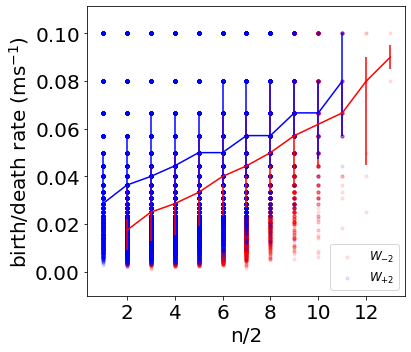

In [124]:
saving = True

savefig_dir = f'{nb_dir}/Figures/birth_death_analysis'
savefig_fn = 'birth_death_rates_ic2-from-log.png'
# savefig_fn = 'birth_death_rates_log.png'
log_scale = False
fontsize=20
figsize=(6,5)

# def birth_death_plot(*y_axis_struct_list):

# plot birth death rates with IQR y error bars with n on the x axis
fig, ax = plt.subplots(figsize=figsize)
for scatter_data, errorbar_data, formatting_data in zip(
    scatter_data_list, errorbar_data_list, formatting_data_list):

    dn, x_values, y_values = scatter_data.values()
    dn, n_list, y_val_list, y_err_1_list, y_err_2_list = errorbar_data.values()
    dn, color, label = formatting_data.values()
    yerr = np.array(list(zip(y_err_1_list,y_err_2_list))).T
    
    ax.scatter(x=x_values/2,y=y_values, c=color, s=10, alpha=0.1, label=label)
    ax.errorbar([n/2 for n in n_list], y_val_list, yerr=yerr, c=color)
    
# ax.legend(loc='top')

ax.set_xticks([2,4,6,8, 10, 12])
# # ax.set_yticks([0,10,20,30,40,50])
# ymin, ymax = ax.get_ylim()
# ax.set_ylim((1e-3,0.4))

ax.legend(loc='best', fontsize= fontsize-8)
ax.tick_params(axis='both', labelsize= fontsize)
ax.set_ylabel('birth/death rate (ms$^{-1}$)', fontsize=fontsize)
ax.set_xlabel('n/2', fontsize=fontsize) 
if log_scale:
    ax.set_yscale('log')
# ax.set_title(f'$\sigma = {sigma}$, threshold = {threshold}', fontsize=fontsize)
                    
# ax.set_title('high frequency birth deaths observed', fontsize=fontsize)
# ax.axis([20,60,0,7])
  
    
if not saving: 
    plt.show() 
else:
    plt.tight_layout()
    os.chdir(savefig_dir)
    plt.savefig(savefig_fn, dpi=300)
    print(f"saved figure in \n\t{savefig_fn}.")


In [78]:
# import trackpy
y_values.shape
# trackpy.link_iter?

(36573,)

In [86]:
#the number when considering rates <= 0.1, we have
y_values.shape

(22972,)

In [26]:
df.n.values.shape

(6791,)

In [125]:
df[(df.n%2==1)]

,Unnamed: 0,t,n,dn,rates


In [28]:
df.iloc[14]

index    208.000
t        620.025
n          4.000
dn         2.000
rates      0.400
Name: 14, dtype: float64

In [29]:
# from lib.birth_death_rates_from_ic import *
# initial_condition_dir = '/Users/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-1/ic-in/ic_200x200.121.33.npz'
# birth_death_rates_from_ic(initial_condition_dir)

### warning! odd tips detected!  Have no/less fear... This is in the filtered n, not in the raw n.
These could be caused by 
- (made padding huge, problem still persists)padding being too small (with this new D)
- something funny in the tracking
    - pad=5
    - edge_tolerance = 3

In [30]:
# save_every_n_frames = 100

In [31]:
10**6/10/10**3

100.0

In [32]:
print(f"the max termination time was {np.max(termination_times)/10**3:.2f} seconds.")

the max termination time was 24.21 seconds.


my max duration was 6.18 seconds.  wouter's mean termination time was ~26 seconds

he saw 405 events, I saw ~3000 events

# plot an odd birth death event's trajectory

In [33]:
#TODO: load a given trajectory file,
#find file interactively/
print("please select a file from within the desired folder.")
file = search_for_file()

please select a file from within the desired folder.
File: /home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-2/ds_5_param_set_8/trajectories/ic_200x200.001.13_ds_5_sigma_1.5_threshold_0.6_sr_10_mem_2_traj.csv


In [34]:
def check_csv_for_odds(file):
    df = pd.read_csv(file)
    return (df.n%2==1).any()

In [40]:
folder_name = os.path.dirname(file)
os.chdir(folder_name)
file_name_list = !ls
file_name_list = [f for f in file_name_list if is_csv(f)]

In [41]:
for f in file_name_list:
#     print(f)
    assert(not  check_csv_for_odds(f) )

In [42]:
# f = 'ic_200x200.001.11_ds_5_sigma_1.5_threshold_0.6_sr_50_mem_2_traj.csv'
df = pd.read_csv(f)
print(f)

ic_200x200.019.33_ds_5_sigma_1.5_threshold_0.6_sr_10_mem_2_traj.csv


In [43]:
df.loc[df.n%2==1]
#TODO: compute change in RAW spiral tip number
#TODO: can I find any ODD changes in the RAW spiral tip number?


,t,x,y,s1,s2,n,V,f,s,frame,particle


In [44]:
check_csv_for_odds(f)

False

## view odd trajectory

In [58]:
file_name_traj = f.replace('_tmin_100_LT_0_bdrates','_traj')
folder_name_traj = folder_name.replace('birth-death-rates','trajectories')

In [59]:
os.chdir(folder_name_traj)
df = pd.read_csv(file_name_traj)

In [62]:
(df.n%2==1).any()

False

The first odd birth death event in the bdrates for ic_200x200.003.32 does not exist in the raw tip number data.  The problem must lie strictly between the tip detection and the final computation of number of tip trajectories.

- TODO(option A): compute the birth-death rates from the raw tip number
    - TODO: LOG TO BDRATES
        - 1. import log and isolate n timeseries
        - 1. use the existing method to compute birth-death rates
- TODO(option B): tune the tracking to get the right tip number.  This is already partially done in another .ipynb

In [63]:
file_name_traj

'ic_200x200.003.32_ds_5_sigma_1.5_threshold_0.6_sr_10_mem_2_traj.csv'

# view kwargs

No RAW odd spiral tips exist in the new spiral tip data

TODO(after finding the tracking problem): CHECK if RAW odd spiral tips exist in the OLD spiral tip data.

THUS, it is in the tracking. RETRY with LT_thresh=0

In [63]:
#TODO(later): compute the spiral tip number from the number of tips to confirm it is from the tracking (waste of time)
# TODO: recompute all trajectories with LT=0 and see if the problem goes away


In [2]:
#DONE: get the function for computing bdrates from trajectory file
#DONE: get kwargs, give it width and height = 200 pixels
#TODO: archive old bdrates
#TODO: recompute bdrates WITH LT_THRESH=0, see if the problem goes away,
#TODO: if it does, recompute on the ic-suite-1 results with LT=0 and see if the problem goes away.


file = '/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-2/ic-out/ic_200x200.001.13.npz'

In [3]:
from lib.birth_death_rates_from_ic import _get_kwargs, compute_birth_death_rates


#NOTE kwargs need to be initial conditions, NOT .trajectory files
kwargs = _get_kwargs(file)
kwargs['width']=200
kwargs['height']=200
kwargs['LT_thresh'] = 0

In [5]:
# os.chdir('..')
# os.path.abspath(file)
kwargs

{'beeping': False,
 'asserting': False,
 'printing': True,
 'plotting': False,
 'logging': True,
 'sigma': 1.5,
 'threshold': 0.6,
 'V_threshold': 0.5,
 'edge_tolerance': 20,
 'pad': 21,
 'atol': 1e-10,
 'color_values': None,
 'h': 0.025,
 'nsteps': 10000000,
 'save_every_n_frames': 100,
 'max_time': 250000.0,
 'max_buffers_to_save': 0,
 'buffers_saved_counter': 0,
 'start_saving_buffers_at_step': 0,
 'timing': False,
 'recording_if_odd': True,
 'recording': True,
 'descrip': 'sigma_1.5_threshold_0.6',
 'save': True,
 'mem': 2,
 'sr': 10,
 'ds': 5,
 'tmin': 100,
 'LT_thresh': 0,
 'base_dir': '/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-2',
 'base_save_dir': '/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-2/ds_5_param_set_8',
 'data_folder_bdrates': '/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-2/ds_5_param_set_8/birth-death-rates',
 'data_folder_traj': '/home/timothytyree/Document

In [101]:
for file in file_name_list:
    retval = compute_birth_death_rates(data_fn_trajectories=os.path.abspath(file),**kwargs)

loading trajectories from data_fn_traj: /home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-2/ds_5_param_set_8/ic_200x200.001.11_ds_5_sigma_1.5_threshold_0.6_sr_50_mem_2_traj.csv.


FileNotFoundError: [Errno 2] File /home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-2/ds_5_param_set_8/ic_200x200.001.11_ds_5_sigma_1.5_threshold_0.6_sr_50_mem_2_traj.csv does not exist: '/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-2/ds_5_param_set_8/ic_200x200.001.11_ds_5_sigma_1.5_threshold_0.6_sr_50_mem_2_traj.csv'

In [100]:
kwargs['data_folder_traj']

'/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-2/ds_5_param_set_8/trajectories'

#IT's hard to check .  file's not found.  just rerun with LT_thresh set to zero 
- Result: odd tips exist even when LT is zero
- try rerunning with a large runtime and with lt=0
    - 

# compute birth-death rates for a folder of tip logs

In [55]:
def log_to_bdrates(input_file_name, output_file_name):
    '''imports a raw output tip log file from input_file_name and saves to a birth-death rate file in output_file_name. '''
    df = pd.read_csv(input_file_name)

    #extract n_series
    n_list = []
    for i, row in df.iterrows():
        n = len(eval(row.x))
        n_list.append(n)
    df['n'] = n_list
    n_series = df.n
    n_series.index = df.t

    #compute birth-death rates
    #store as a pandas.DataFrame
    df = pd.DataFrame({"t":n_series.index.values,"n":n_series.values})

    #compute birth death rates
    df['dn'] = df.n.diff().shift(-1)
    df = df.query('dn != 0').copy()
    rates = 1/df['t'].diff().shift(-1).dropna() # birth death rates in unites of 1/ms
    df['rates'] = rates

    #save birth death rates to a file named according to all of the relevant parameters in a special folder.
    df.to_csv(output_file_name)
    return True

In [56]:
#get a folder of filenames of tip log files ending in log.csv
#find file interactively
print("please select a file from within the desired folder.")
file = search_for_file()
folder_name = os.path.dirname(file)
os.chdir(folder_name)

# get all .csv files in the current working directory
retval = !ls
file_name_list = list(retval)
# check each file if it ends in .csv before merging it
def is_target(file_name, target = '_log.csv'):
    return file_name[-len(target):]==target


file_name_list = [f for f in file_name_list if is_target(f, target = 'log.csv')]
# file_name_list = [f for f in file_name_list if f.find('threshold')!=-1]




please select a file from within the desired folder.
File: /home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-2/ds_5_param_set_8/Log/ic_200x200.014.32_ds_5_sigma_1.5_threshold_0.6_log.csv


In [57]:
#create a save_folder, for bdrates if it doesn't already exist
save_folder = folder_name.replace('/Log','/birth-death-rates-from-log-simplified')
if not os.path.exists(save_folder):
    os.mkdir(save_folder)

In [60]:
print(len(file_name_list))

171


In [61]:
#for each file in the folder, compute the birth-death rates
#TODO(later): daskbag accelerate this process
os.chdir(folder_name)
for input_file_name in file_name_list:
    output_file_name = input_file_name.replace('log.csv','bdrates.csv')
    output_dir = os.path.join(save_folder,output_file_name)
    log_to_bdrates(input_file_name=input_file_name, 
                   output_file_name=output_dir)

In [62]:
beep(3)

0

In [63]:
#9 samples LT = 0
# file =  '/Users/timothytyree/Documents/GitHub/care/notebooks/Data/ds_5_param_set_8/birth-death-rates/33_ds_5_sigma_1.5_threshold_0.6__traj_sr_40_mem_2_bdrates.csv'

#>60 samples LT = 2
file = search_for_file()
# file = '/Users/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-1/ds_5_param_set_8/birth-death-rates/ic_200x200.117.21_ds_5_sigma_1.5_threshold_0.6_sr_50_mem_2_tmin_100_LT_2_bdrates.csv'
#change to the directory containing file
folder_name = os.path.dirname(file)


#find folder interactively. Crashes jupyter's root kernel :(
# from tkinter import Tk
# from tkinter.filedialog import askdirectory
# path = askdirectory(title='Select Folder') # shows dialog box and return the path
# print(path) 

File: /home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-2/ds_5_param_set_8/birth-death-rates-from-log-simplified/ic_200x200.001.12_ds_5_sigma_1.5_threshold_0.6_bdrates.csv


In [64]:
# get all .csv files in the current working directory
os.chdir(folder_name)
retval = !ls
file_name_list = list(retval)
# check each file if it ends in .csv before merging it
def is_csv(file_name):
    return file_name[-4:]=='.csv'
file_name_list = [f for f in file_name_list if is_csv(f)]
# remove all files with 'threshold'
# file_name_list = [f for f in file_name_list if f.find('threshold')==-1]

In [65]:
print(len(file_name_list))

171


In [66]:

print(file_name_list)

['ic_200x200.001.11_ds_5_sigma_1.5_threshold_0.6_bdrates.csv', 'ic_200x200.001.12_ds_5_sigma_1.5_threshold_0.6_bdrates.csv', 'ic_200x200.001.13_ds_5_sigma_1.5_threshold_0.6_bdrates.csv', 'ic_200x200.001.21_ds_5_sigma_1.5_threshold_0.6_bdrates.csv', 'ic_200x200.001.22_ds_5_sigma_1.5_threshold_0.6_bdrates.csv', 'ic_200x200.001.23_ds_5_sigma_1.5_threshold_0.6_bdrates.csv', 'ic_200x200.001.31_ds_5_sigma_1.5_threshold_0.6_bdrates.csv', 'ic_200x200.001.32_ds_5_sigma_1.5_threshold_0.6_bdrates.csv', 'ic_200x200.001.33_bdrates.csv', 'ic_200x200.002.11_bdrates.csv', 'ic_200x200.002.12_bdrates.csv', 'ic_200x200.002.13_bdrates.csv', 'ic_200x200.002.21_bdrates.csv', 'ic_200x200.002.22_bdrates.csv', 'ic_200x200.002.23_bdrates.csv', 'ic_200x200.002.31_bdrates.csv', 'ic_200x200.002.32_bdrates.csv', 'ic_200x200.002.33_bdrates.csv', 'ic_200x200.003.11_bdrates.csv', 'ic_200x200.003.12_bdrates.csv', 'ic_200x200.003.13_bdrates.csv', 'ic_200x200.003.21_bdrates.csv', 'ic_200x200.003.22_bdrates.csv', 'ic_200x

In [67]:
def produce_one_csv(list_of_files, file_out):
   # Consolidate all csv files into one object
   result_obj = pd.concat([pd.read_csv(file) for file in list_of_files])
   # Convert the above object into a csv file and export
   result_obj.to_csv(file_out, index=False, encoding="utf-8")

In [68]:
# file_out = "../consolidated_rates.csv"
file_out = "../consolidated_rates-from-log.csv"
produce_one_csv(list_of_files=file_name_list, file_out=file_out)

# TODO: plot the resultingtermination times for the desired folder of bdrates
and then, document this, comparing to WJ's old results.  Do this with a .pdf made in OpenOffice Draw

# TODO: make .csv of termination times of trials

In [72]:
#for one input_file_name .csv get its termination time
file = search_for_file()


File: /home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-2/ds_5_param_set_8/birth-death-rates-from-log-simplifiedd-set-A/ic_200x200.001.21_ds_5_sigma_1.5_threshold_0.6_bdrates.csv


In [27]:
folder_name = os.path.dirname(file)
file_name = os.path.basename(file)

In [45]:
def get_termination_time(input_file_name):
    df = pd.read_csv(input_file_name)
    tt = float(df.loc[df.isna()['rates']]['t'].values)
    return tt

In [75]:
folder_name = "/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-2/ds_5_param_set_8/birth-death-rates-from-log-simplified-set-B/"

# get all .csv files in the current working directory
os.chdir(folder_name)
retval = !ls
file_name_list = list(retval)
# check each file if it ends in .csv before merging it
def is_csv(file_name):
    return file_name[-4:]=='.csv'
file_name_list = [f for f in file_name_list if is_csv(f)]
print(len(file_name_list))

61


In [76]:
os.chdir(folder_name)
fn_lst = []; tt_lst = []; ic_lst = []; part_lst = []; method_lst = [];
for input_file_name in file_name_list:
    file_name = os.path.basename(input_file_name)
    tt = get_termination_time(input_file_name)
    
    ic = file_name.split('.')[1]
    part = file_name.split('.')[2].split('_')[0]
    
    fn_lst.append(file_name)
    tt_lst.append(tt)
    ic_lst.append(ic)
    part_lst.append(part)
    method_lst.append('B')

In [77]:
folder_name = "/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-2/ds_5_param_set_8/birth-death-rates-from-log-simplified-set-A"

# get all .csv files in the current working directory
os.chdir(folder_name)
retval = !ls
file_name_list = list(retval)
# check each file if it ends in .csv before merging it
def is_csv(file_name):
    return file_name[-4:]=='.csv'
file_name_list = [f for f in file_name_list if is_csv(f)]
print(len(file_name_list))


110


In [78]:
os.chdir(folder_name)
# fn_lst = []; tt_lst = []; ic_lst = []; part_lst = []; method_lst = [];
for input_file_name in file_name_list:
    file_name = os.path.basename(input_file_name)
    tt = get_termination_time(input_file_name)
    
    ic = file_name.split('.')[1]
    part = file_name.split('.')[2].split('_')[0]
    
    fn_lst.append(file_name)
    tt_lst.append(tt)
    ic_lst.append(ic)
    part_lst.append(part)
    method_lst.append('A')

In [79]:
df = pd.DataFrame({'ic':ic_lst, 'part':part_lst, 'term_time':tt_lst, 'method':method_lst, 'file_name':fn_lst})

In [86]:
save_folder = os.path.join(nb_dir,'Data','initial-conditions-suite-2/ds_5_param_set_8')
os.chdir(save_folder)
df.to_csv('termination_times_ic_001-019.csv', index=False)

### plot termination times

In [3]:
file = "/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-2/ds_5_param_set_8_laurener_archive/archive-laurener/termination_times_ic_001-019.csv"

In [4]:
df = pd.read_csv(file)

In [5]:
df.head()

,ic,part,term_time,method,file_name
0,1,33,96605.0,B,ic_200x200.001.33_bdrates.csv
1,2,11,51365.0,B,ic_200x200.002.11_bdrates.csv
2,2,12,65162.5,B,ic_200x200.002.12_bdrates.csv
3,2,13,70932.5,B,ic_200x200.002.13_bdrates.csv
4,2,21,24097.5,B,ic_200x200.002.21_bdrates.csv


In [8]:
termination_times = df.term_time.values

saved figure in 
	histogram_termination_times_suite-2-log.png.


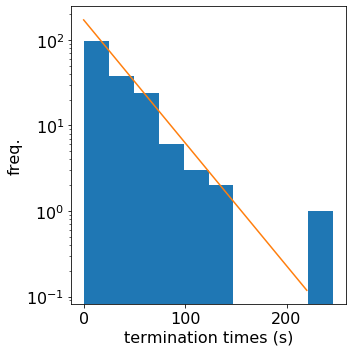

In [10]:
r = 10**3/np.mean(termination_times)
def P(k,t):
    '''the probability that k events occur in time t'''
    return (r*t)**k*np.exp(-r*t)/np.math.factorial(k)

#plot the histogram of termination times
saving = True
fontsize=16

savefig_dir = f'{nb_dir}/Figures/birth_death_analysis'
savefig_fn = 'histogram_termination_times_suite-2-log.png'

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(np.array(termination_times)/10**3, bins = 10)

#overlay a poisson distribution
N = len(termination_times)
x_values = np.linspace(1,220000,100)/10**3
y_values = N*P(0,x_values)
ax.plot(x_values,y_values)

#format plot
# plt.title(f'''termination times for 9 200x200 patches''', fontsize=fontsize)
ax.set_ylabel('freq.', fontsize=fontsize)
ax.set_xlabel('termination times (s)', fontsize=fontsize)
ax.tick_params(axis='both', which='both', labelsize=fontsize)
# ax.set_ylim((0,80))
ax.set_yscale('log')
if not saving: 
    plt.show() 
else:
    plt.tight_layout()
    os.chdir(savefig_dir)
    plt.savefig(savefig_fn, dpi=300)
    print(f"saved figure in \n\t{savefig_fn}.")

In [12]:
np.mean(termination_times)

30240.352339083354

In [13]:
np.std(termination_times)

32597.54377007532